# Optimisation: Bare-bones CMA-ES

PINTS has two implementations of the CMA-ES algorithm:

1. The main one, called [CMA-ES](http://pints.readthedocs.io/en/latest/optimisers/cmaes.html), wraps around a battle-tested routine by the original authors of the algorithm.
   This is the version we recommend for normal use.
2. For users interested in exploring the algorhitm, PINTS also contains a [bare-bones CMA-ES reimplementation](http://pints.readthedocs.io/en/latest/optimisers/cmaes_bare.html).
   This version doesn't have all the features of the main implementation, which may make it easier to understand or compare to other, similar, algorithms.

In this example we visualise a short optimisation with CMA-ES.

## Example 1: finding the bottom of a parabolic valley

We start off by defining a simple error function: a parabola centered at the origin:

In [1]:
import pints
import pints.toy

# Create a parabolic error function
error = pints.toy.ParabolicError()

To see what this function looks like, we'll use a contour plot.

This will get re-used throughout the example, so we define a function to create it:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the error function on a grid of points
X = np.linspace(-2, 2, 40)
Y = np.linspace(-1, 1, 20)
Z = np.zeros((len(Y), len(X)))
for i, x in enumerate(X):
    for j, y in enumerate(Y):
        Z[j, i] = error((x, y))
X, Y = np.meshgrid(X, Y)

# Define a function to create a contour plot
def create_contour_plot():

    # Create figure
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 1, 1)
    plt.xlim(-2, 2)
    plt.ylim(-1, 1)
    
    # Plot the contours
    plt.contour(X, Y, Z, levels=20)
    
    # Show where the optimum is
    plt.plot([0], [0], 'o', label='optimum')
    
    # Return axes object
    return ax

Next, we'll choose a starting point for our optimisation, and plot it on the contours of the error function:

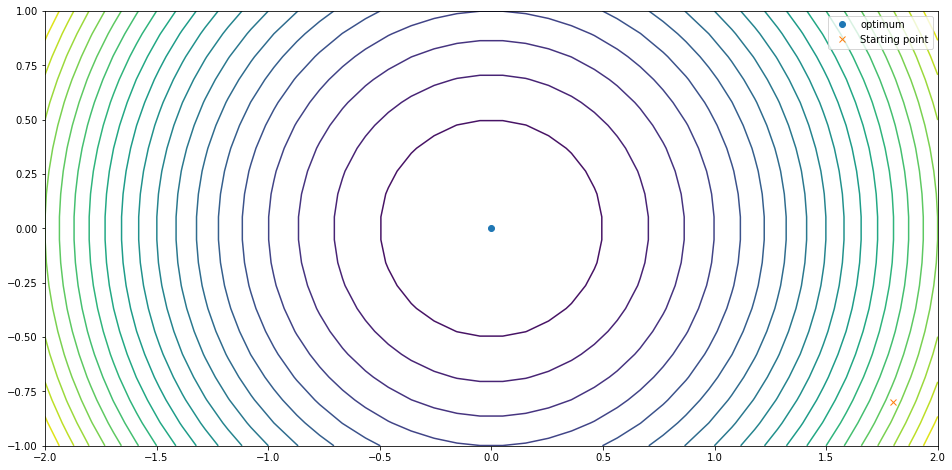

In [3]:
# Create a contour plot
create_contour_plot()

# Choose a starting point for the optimisation
x0 = [1.8, -0.8]

# Show the starting point
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Show the whole figure
plt.legend()
plt.show()

At this stage, our problem is all set up.

The next thing to do is to create a bare-bones CMA-ES optimiser, and use the ask-and-tell interface to let it walk a few steps. We can use the `mean()` method to obtain the CMA-ES optimiser's current position:

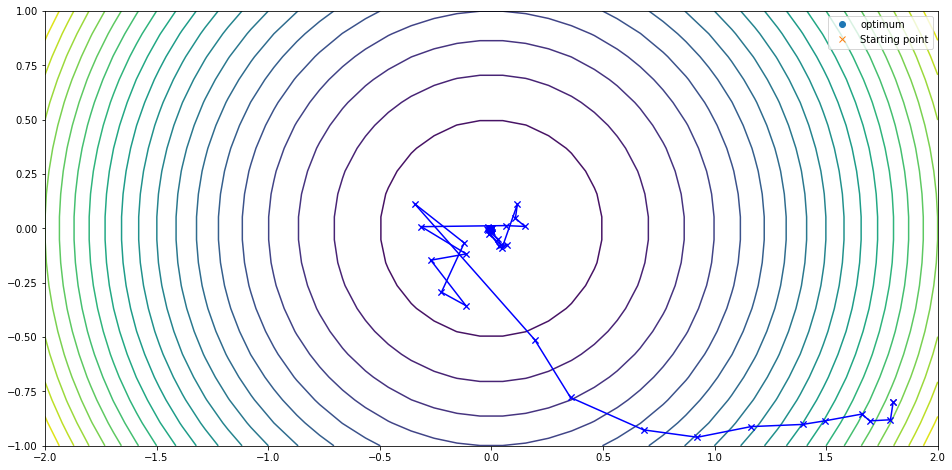

In [4]:
# Create an evaluator to evaluate the error function
e = pints.SequentialEvaluator(error)

# Seed numpy's random generator:
# We do this here just so that we get the same results when we repeat this later in the example.
np.random.seed(1)

# Create a CMA-ES optimiser
opt = pints.BareCMAES(x0)

# Create a nice plot
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Walk a few steps, and plot the results
x1 = x0
for i in range(50):
    x2 = opt.mean()
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2
    
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)

# Show the whole figure
plt.legend()
plt.show()

We can get a better idea of what the CMA-ES optimiser does by looking at its _covariance matrix_.


At each step of an iteration, CMA-ES
- samples points randomly drawn from a distribution centered at $\mu$, with covariance matrix $C$
- evaluates the objective function for each of these points
- makes a selection of the best points, and uses these to move $\mu$ and adapt the covariance matrix.

the methods it uses for adaptation are quite complex, but we can see $C$ changing over time by representing it as an ellipse and plotting it:

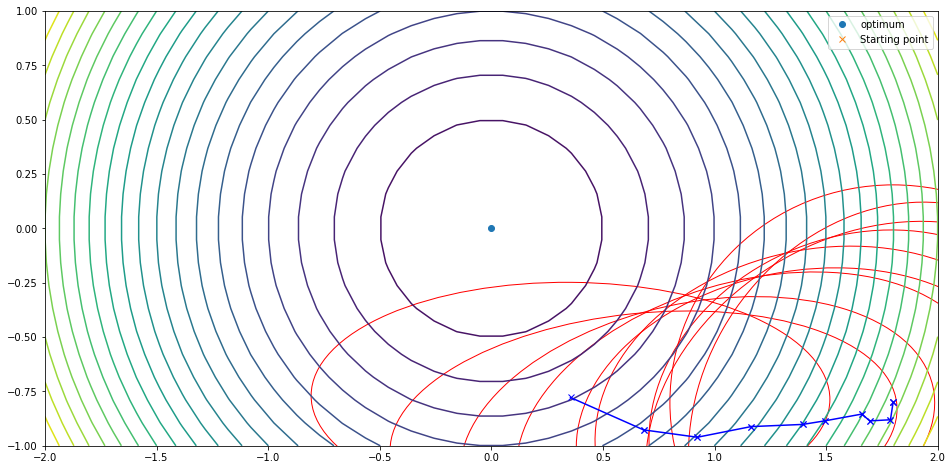

In [5]:
from matplotlib.patches import Ellipse

# Seed numpy's random generator, to get the same results as before
np.random.seed(1)

# Create a CMA-ES optimiser
opt = pints.BareCMAES(x0)

# Create a nice plot
ax = create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Walk a few steps, and plot the results
x1 = x0
for i in range(10):
    x2 = opt.mean()
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    
    # Get eigenvalues and eigenvectors of covariance matrix
    R, S = opt.cov(decomposed=True)
    
    # Draw ellipse:
    #   width = 2 * first eigenvalue
    #   height = 2 * second eigenvalue
    #   rotation = angle made by first eigenvector
    w = 2 * S[0, 0]     # First eigenvalue
    h = 2 * S[1, 1]     # Second eigenvalue
    t = np.arctan2(R[1, 0], R[0, 0])  # Angle of first eigenvector
    ellipse = Ellipse(
        x2, w, h, 
        angle=t * 180 / np.pi,
        facecolor='none',
        edgecolor='red',
    )
    ax.add_patch(ellipse)

    # Update point
    x1 = x2
    
    # Move to next point
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)

# Show the whole figure
plt.legend()
plt.show()

As before, we can see the center of the proposal distribution moving towards the optimum (blue crosses), but now we also see that the covariance matrix is moving along, and rotating.
Notice that the distribution stays quite wide, causing CMA-ES to sample from a large area.
This can help make the method robust against noise.

The large size of the proposal distribution also explains why the movement of CMA-ES is somewhat erratic, as it samples randomly within this large area to determine the next step.

We can let it run a bit longer to see what happens near an optimum:

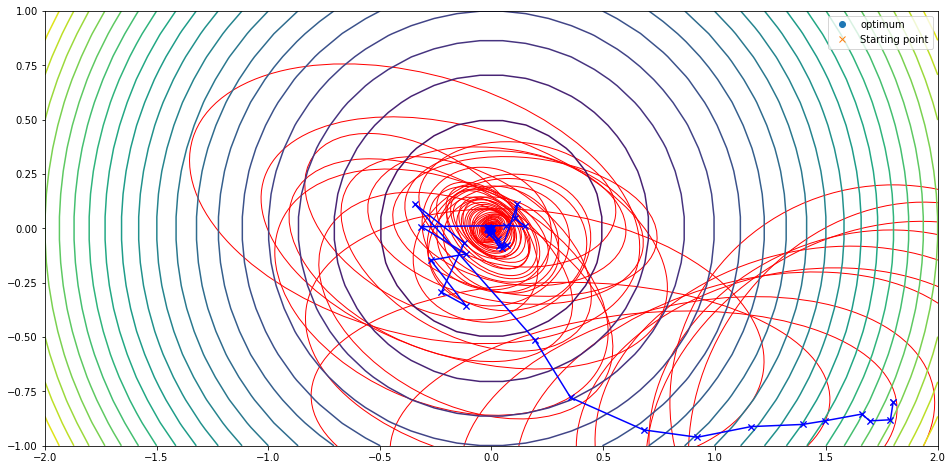

In [6]:
# Seed numpy's random generator, to get the same results as before
np.random.seed(1)

# Create a CMA-ES optimiser
opt = pints.BareCMAES(x0)

# Create a nice plot
ax = create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Walk a few steps, and plot the results
x1 = x0
for i in range(70):
    x2 = opt.mean()
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    
    # Get eigenvalues and eigenvectors of covariance matrix
    R, S = opt.cov(decomposed=True)
    
    # Draw ellipse:
    #   width = 2 * first eigenvalue
    #   height = 2 * second eigenvalue
    #   rotation = angle made by first eigenvector
    w = 2 * S[0, 0]     # First eigenvalue
    h = 2 * S[1, 1]     # Second eigenvalue
    t = np.arctan2(R[1, 0], R[0, 0])  # Angle of first eigenvector
    ellipse = Ellipse(
        x2, w, h, 
        angle=t * 180 / np.pi,
        facecolor='none',
        edgecolor='red',
    )
    ax.add_patch(ellipse)

    # Update point
    x1 = x2
    
    # Move to next point
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)

# Show the whole figure
plt.legend()
plt.show()

Note how the covariance matrix shrinks rapidly once the method gets near the optimum. 
This adaptation allows CMA-ES to "zoom in" on the optimum, using much smaller steps to get an accurate result.

## Example 2: A harder problem

We'll now try this method on a harder problem, the [twisted Gaussian LogPDF](https://pints.readthedocs.io/en/latest/toy/twisted_gaussian_logpdf.html).
Because this is a LogPDF, we convert it to an ErrorMeasure using a [pints.ProbabilityBasedError](https://pints.readthedocs.io/en/latest/error_measures.html#pints.ProbabilityBasedError).


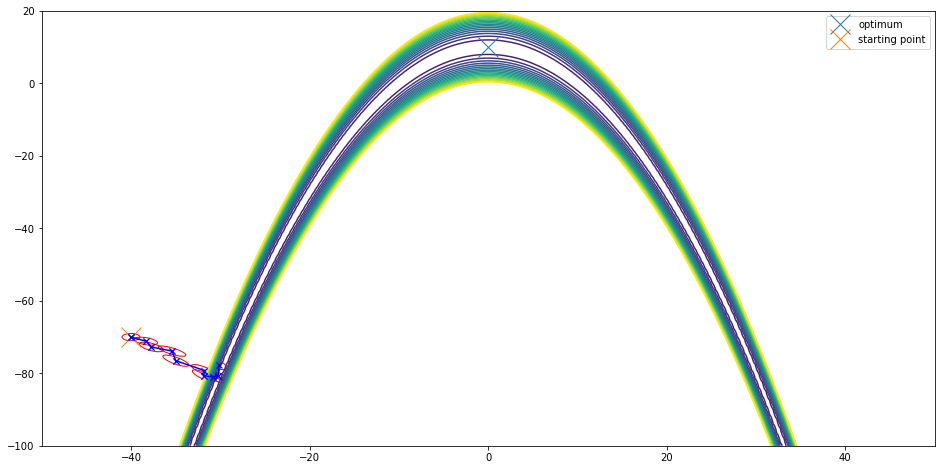

In [7]:
# Define a LogPDF (a 2-dimensional twisted gaussian)
logpdf = pints.toy.TwistedGaussianLogPDF(dimension=2)

# Wrap an error around the LogPDF
error = pints.ProbabilityBasedError(logpdf)

# Create figure
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
plt.xlim(-50, 50)
plt.ylim(-100, 20)

# Evaluate the error function on a grid of points
levels = np.linspace(1, 50, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]
plt.contour(X, Y, Z, levels=levels)

# Show the optimum
plt.plot(0, 10, 'x', markersize=20, label='optimum')

# Pick a starting point
x0 = [-40, -70]
plt.plot(x0[0], x0[1], 'x', markersize=20, label='starting point')

# Seed the random number generator again
np.random.seed(1)

# Create an optimiser
opt = pints.BareCMAES(x0, sigma0=1)

# Create an evaluator to evaluate the error function
e = pints.ParallelEvaluator(error)

# Walk a few steps, and plot the results
x1 = x0
for i in range(10):
    x2 = opt.mean()
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')

    # Draw ellipse
    R, S = opt.cov(decomposed=True)
    w = 2 * S[0, 0]     # First eigenvalue
    h = 2 * S[1, 1]     # Second eigenvalue
    t = np.arctan2(R[1, 0], R[0, 0])  # Angle of first eigenvector
    ellipse = Ellipse(
        x2, w, h, 
        angle=t * 180 / np.pi,
        facecolor='none',
        edgecolor='red',
    )
    ax.add_patch(ellipse)  
    x1 = x2

    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
# Show the whole figure
plt.legend()
plt.show()

The initial behaviour looks promising, CMA-ES quickly moves towards the "banana", and then seems to slow down a bit.

We let it run some longer:

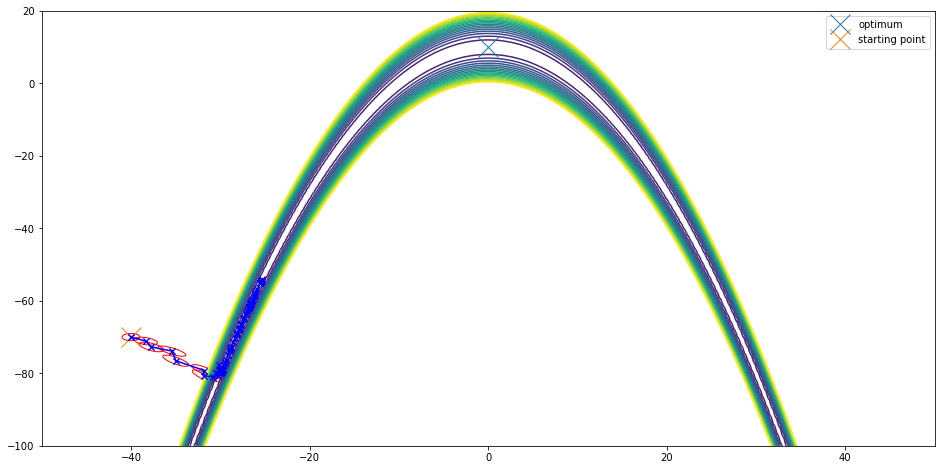

In [8]:
# Create figure
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.contour(X, Y, Z, levels=levels)
plt.plot(0, 10, 'x', markersize=20, label='optimum')
plt.plot(x0[0], x0[1], 'x', markersize=20, label='starting point')

# Seed the random number generator again
np.random.seed(1)

# Create an optimiser
opt = pints.BareCMAES(x0, sigma0=1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(100):
    x2 = opt.mean()
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')

    # Draw ellipse
    R, S = opt.cov(decomposed=True)
    w = 2 * S[0, 0]     # First eigenvalue
    h = 2 * S[1, 1]     # Second eigenvalue
    t = np.arctan2(R[1, 0], R[0, 0])  # Angle of first eigenvector
    ellipse = Ellipse(
        x2, w, h, 
        angle=t * 180 / np.pi,
        facecolor='none',
        edgecolor='red',
    )
    ax.add_patch(ellipse)  
    x1 = x2

    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
# Show the whole figure
plt.legend()
plt.show()

It's not moving fast anymore, but the method is making its way towards the optimum.
Let's try even more iterations:

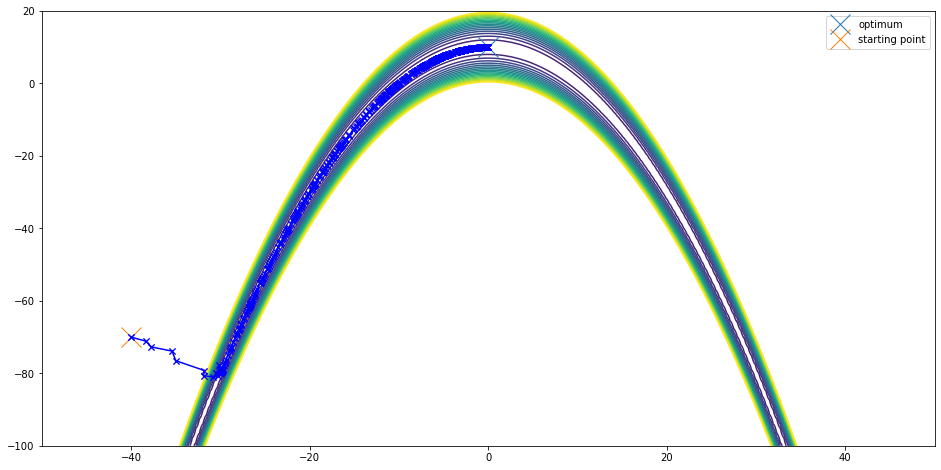

In [9]:
# Create figure
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
plt.xlim(-50, 50)
plt.ylim(-100, 20)
plt.contour(X, Y, Z, levels=levels)
plt.plot(0, 10, 'x', markersize=20, label='optimum')
plt.plot(x0[0], x0[1], 'x', markersize=20, label='starting point')

# Seed the random number generator again
np.random.seed(1)

# Create an optimiser
opt = pints.BareCMAES(x0, sigma0=1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(700):
    x2 = opt.mean()
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
# Show the whole figure
plt.legend()
plt.show()